# Zeeguu Architecture Reconstruction with Pyreverse

This notebook demonstrates how to use Pyreverse (provided with Pylint) to perform architecture reconstruction on the Zeeguu project, focusing solely on the backend (Zeeguu API).

## Overview

- **Zeeguu API (backend):** located in `Data/api`

Before proceeding, ensure that Pylint (which includes Pyreverse) is installed, and that Graphviz is installed and configured on your system (its bin folder must be in your PATH).

## 1. Generate Basic UML Diagrams

We will now generate basic UML diagrams for the API (backend). The output files will be stored in the directory defined by `PYREVERSE_OUTPUT_DIR`.

In [1]:
import os
import sys
import subprocess
import tempfile
import shutil
import ast

############################
# Global path configuration
############################

# Tools directory is the current working directory (expected to be .../Tools)
TOOLS_DIR = os.getcwd()

# BASE_DIR is one level up from TOOLS_DIR
BASE_DIR = os.path.abspath(os.path.join(TOOLS_DIR, '..'))

# DATA_DIR is in BASE_DIR/Data
DATA_DIR = os.path.join(BASE_DIR, 'Data')

# API repository to analyze is in DATA_DIR/api
API_DIR = os.path.join(DATA_DIR, 'api')

# All Pyreverse outputs (diagrams, dot files, etc.) will be placed here
PYREVERSE_OUTPUT_DIR = os.path.join(BASE_DIR, 'output', 'pyreverse')
os.makedirs(PYREVERSE_OUTPUT_DIR, exist_ok=True)

print("TOOLS_DIR:", TOOLS_DIR)
print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("API_DIR:", API_DIR)
print("PYREVERSE_OUTPUT_DIR:", PYREVERSE_OUTPUT_DIR)

# Set the working directory to TOOLS_DIR
os.chdir(TOOLS_DIR)
print(f"Working directory set to: {os.getcwd()}")

############################
# Install required packages
############################

def install_package(package):
    package_name = package.split('==')[0] if '==' in package else package
    try:
        __import__(package_name.replace('-', '_'))
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_package('pylint')
install_package('graphviz')
install_package('pydot')

# Check Pyreverse version using the pyreverse command directly
try:
    subprocess.check_call(["pyreverse", "--version"])
except Exception as e:
    print("Error calling pyreverse. Ensure that the pyreverse command is available on your PATH and that Pylint is installed.")

############################
# AST Transformer to remove type annotations
############################

class RemoveTypeAnnotations(ast.NodeTransformer):
    def visit_FunctionDef(self, node):
        node.returns = None
        for arg in node.args.args:
            arg.annotation = None
        for arg in node.args.kwonlyargs:
            arg.annotation = None
        if node.args.vararg:
            node.args.vararg.annotation = None
        if node.args.kwarg:
            node.args.kwarg.annotation = None
        self.generic_visit(node)
        return node

    def visit_AsyncFunctionDef(self, node):
        node.returns = None
        for arg in node.args.args:
            arg.annotation = None
        for arg in node.args.kwonlyargs:
            arg.annotation = None
        if node.args.vararg:
            node.args.vararg.annotation = None
        if node.args.kwarg:
            node.args.kwarg.annotation = None
        self.generic_visit(node)
        return node

    def visit_AnnAssign(self, node):
        # Convert annotated assignments into simple assignments if a value is present.
        if node.value is not None:
            new_node = ast.Assign(targets=[node.target], value=node.value)
            return self.generic_visit(new_node)
        else:
            # If there's no value, remove the node entirely.
            return None

    def visit_arg(self, node):
        node.annotation = None
        return node

############################
# Create a filtered copy of the repository to analyze
############################

print("Creating a filtered copy of the repository for analysis...")

# Create a temporary directory for the filtered copy
temp_dir = tempfile.mkdtemp(prefix="pyreverse_analysis_")
print(f"Created temporary directory: {temp_dir}")

# List of file patterns to exclude
exclude_patterns = ['test', 'old', '_playground.py', '.git', '__pycache__', '.pyc']

# Function to check if a file/directory should be excluded
def should_exclude(path):
    for pattern in exclude_patterns:
        if pattern in path:
            return True
    return False

# Copy API files, excluding problematic ones
filtered_api_dir = os.path.join(temp_dir, 'api')
os.makedirs(filtered_api_dir)

for root, dirs, files in os.walk(API_DIR):
    # Skip excluded directories
    dirs[:] = [d for d in dirs if not should_exclude(d)]
    
    # Create the corresponding directory structure in the temp directory
    rel_dir = os.path.relpath(root, API_DIR)
    temp_subdir = os.path.join(filtered_api_dir, rel_dir)
    if rel_dir != '.' and not os.path.exists(temp_subdir):
        os.makedirs(temp_subdir)
    
    # Process and copy eligible Python files
    for file in files:
        if file.endswith('.py') and not should_exclude(file):
            src_file = os.path.join(root, file)
            dst_file = os.path.join(temp_subdir, file)
            try:
                with open(src_file, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                
                # Use AST to remove type annotations
                try:
                    tree = ast.parse(content, filename=src_file)
                    transformer = RemoveTypeAnnotations()
                    new_tree = transformer.visit(tree)
                    ast.fix_missing_locations(new_tree)
                    new_content = ast.unparse(new_tree)
                    modified = True
                except Exception as ex:
                    print(f"AST transformation failed for {os.path.relpath(src_file, API_DIR)}: {ex}")
                    new_content = content
                    modified = False
                
                with open(dst_file, 'w', encoding='utf-8') as f:
                    f.write(new_content)
                
                if modified:
                    print(f"Removed type annotations in: {os.path.relpath(src_file, API_DIR)}")
            except Exception as e:
                print(f"Error processing {src_file}: {e}")

print(f"Created filtered copy of API repository at: {filtered_api_dir}")

############################
# Run Pyreverse on the filtered repository
############################

print("Running Pyreverse analysis...")

try:
    result = subprocess.run([
        "pyreverse", 
        filtered_api_dir, 
        "-o", "png", 
        "-p", "zeeguu_api", 
        "-d", PYREVERSE_OUTPUT_DIR,
        "--filter-mode=ALL"
    ], capture_output=True, text=True)
    
    print("STDOUT:")
    print(result.stdout)
    
    if result.returncode == 0:
        print("Pyreverse analysis completed successfully!")
    else:
        print("STDERR:")
        print(result.stderr)
        print(f"Pyreverse returned error code {result.returncode}, but output may still have been generated.")
    
    # Check for output files
    expected_files = [
        os.path.join(PYREVERSE_OUTPUT_DIR, "classes_zeeguu_api.png"),
        os.path.join(PYREVERSE_OUTPUT_DIR, "packages_zeeguu_api.png")
    ]
    
    for file_path in expected_files:
        if os.path.exists(file_path):
            print(f"Generated: {file_path}")
        else:
            print(f"Output file missing: {file_path}")
    
except Exception as e:
    print(f"Error running Pyreverse: {e}")

finally:
    # Clean up the temporary directory
    print(f"Cleaning up temporary directory: {temp_dir}")
    try:
        shutil.rmtree(temp_dir)
    except Exception as e:
        print(f"Warning: Failed to clean up temporary directory: {e}")


TOOLS_DIR: c:\Programming\Architecture\ArchitecturalRecovery\Tools
BASE_DIR: c:\Programming\Architecture\ArchitecturalRecovery
DATA_DIR: c:\Programming\Architecture\ArchitecturalRecovery\Data
API_DIR: c:\Programming\Architecture\ArchitecturalRecovery\Data\api
PYREVERSE_OUTPUT_DIR: c:\Programming\Architecture\ArchitecturalRecovery\output\pyreverse
Working directory set to: c:\Programming\Architecture\ArchitecturalRecovery\Tools
pylint is already installed.
graphviz is already installed.
pydot is already installed.
Creating a filtered copy of the repository for analysis...
Created temporary directory: C:\Users\jgrum\AppData\Local\Temp\pyreverse_analysis__3_rhca3
Removed type annotations in: env_var_defs_default.py
Removed type annotations in: install_stanza_models.py
Removed type annotations in: setup.py
Removed type annotations in: start.py
Removed type annotations in: __init__.py
Removed type annotations in: tools\activity_monitor.py
Removed type annotations in: tools\add_feed.py
Remov

c:\Programming\Architecture\ArchitecturalRecovery\Data\api\zeeguu\api\app.py:84: SyntaxWarning: invalid escape sequence '\-'
  ":([a-zA-Z_][a-zA-Z_0-9\-]*)@", ":****@", db_connection_string


Removed type annotations in: zeeguu\api\app.py
Removed type annotations in: zeeguu\api\cross_domain_app.py
Removed type annotations in: zeeguu\api\custom_fmd_graphs.py
Removed type annotations in: zeeguu\api\__init__.py
Removed type annotations in: zeeguu\api\endpoints\accounts.py
Removed type annotations in: zeeguu\api\endpoints\activity_tracking.py
Removed type annotations in: zeeguu\api\endpoints\article.py
Removed type annotations in: zeeguu\api\endpoints\bookmarks_and_words.py
Removed type annotations in: zeeguu\api\endpoints\exercises.py
Removed type annotations in: zeeguu\api\endpoints\exercise_sessions.py
Removed type annotations in: zeeguu\api\endpoints\feature_toggles.py
Removed type annotations in: zeeguu\api\endpoints\nlp.py
Removed type annotations in: zeeguu\api\endpoints\own_texts.py
Removed type annotations in: zeeguu\api\endpoints\reading_sessions.py
Removed type annotations in: zeeguu\api\endpoints\search.py
Removed type annotations in: zeeguu\api\endpoints\sessions.p

c:\Programming\Architecture\ArchitecturalRecovery\Data\api\zeeguu\core\language\strategies\word_rank_difficulty_estimator.py:63: SyntaxWarning: invalid escape sequence '\d'
  words = [w for w in words if re.search("\d", w) == None]
c:\Programming\Architecture\ArchitecturalRecovery\Data\api\zeeguu\core\model\starred_article.py:71: SyntaxWarning: invalid escape sequence '\ '
  """


Removed type annotations in: zeeguu\core\model\topic_subscription.py
Removed type annotations in: zeeguu\core\model\unique_code.py
Removed type annotations in: zeeguu\core\model\url.py
Removed type annotations in: zeeguu\core\model\url_keyword.py
Removed type annotations in: zeeguu\core\model\user.py
Removed type annotations in: zeeguu\core\model\user_activitiy_data.py
Removed type annotations in: zeeguu\core\model\user_article.py
Removed type annotations in: zeeguu\core\model\user_cohort_map.py
Removed type annotations in: zeeguu\core\model\user_exercise_session.py
Removed type annotations in: zeeguu\core\model\user_feedback.py
Removed type annotations in: zeeguu\core\model\user_language.py
Removed type annotations in: zeeguu\core\model\user_notification.py
Removed type annotations in: zeeguu\core\model\user_preference.py
Removed type annotations in: zeeguu\core\model\user_reading_session.py
Removed type annotations in: zeeguu\core\model\user_word.py
Removed type annotations in: zeegu

## 2. Displaying the Generated Diagrams

Use IPython’s display functions to show the generated API diagrams directly in the notebook.

API Classes Diagram:


API Packages Diagram:


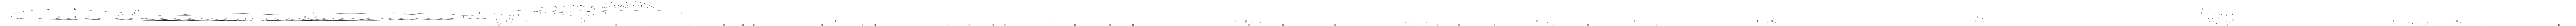

In [2]:
from IPython.display import Image, display

print("API Classes Diagram:")
display(Image(filename=os.path.join(PYREVERSE_OUTPUT_DIR, 'classes_zeeguu_api.png')))

print("API Packages Diagram:")
display(Image(filename=os.path.join(PYREVERSE_OUTPUT_DIR, 'packages_zeeguu_api.png')))

## 3. Advanced Pyreverse Options

Pyreverse offers several advanced options to refine the generated diagrams. Run the help command below to see all options available:

In [3]:
import subprocess

subprocess.check_call(["pyreverse", "--help"])


0

## 4. Focused Analysis and Filtering

You can generate more focused diagrams by filtering specific modules. For example, below we list some key modules from the API.

In [4]:
import sys
import subprocess

# Use BASE_DIR as the project root
project_root = BASE_DIR
print("Project root:", project_root)

# Ensure project_root is in sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Use the new output directory
output_dir = PYREVERSE_OUTPUT_DIR
print("Output directory:", output_dir)

# Prepare the environment: add BASE_DIR to PYTHONPATH
env = os.environ.copy()
env["PYTHONPATH"] = project_root + os.pathsep + env.get("PYTHONPATH", "")

# Run the Pyreverse command using fully qualified module names, filtering by module
subprocess.check_call([
    "pyreverse", "Data.api.zeeguu", "-o", "png",
    "-p", "zeeguu_core_modules", "-d", output_dir, "--only-classname"
], cwd=project_root, env=env)


Project root: c:\Programming\Architecture\ArchitecturalRecovery
Output directory: c:\Programming\Architecture\ArchitecturalRecovery\output\pyreverse


0

# 8 dot files

The next section shows how to customize DOT files for improved visualization.

Project root: c:\Programming\Architecture\ArchitecturalRecovery
API Repository root: c:\Programming\Architecture\ArchitecturalRecovery\Data\api
Output directory: c:\Programming\Architecture\ArchitecturalRecovery\output\pyreverse
Creating module view for: zeeguu.core
Running command: pyreverse zeeguu.core -o dot -p zeeguu_core_view -d c:\Programming\Architecture\ArchitecturalRecovery\output\pyreverse\custom --ignore=test,__pycache__ --module-names=y --only-classname

Zeeguu Core Components Viewpoint:


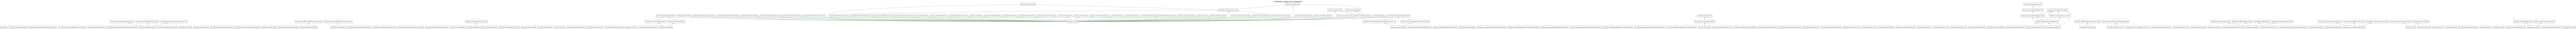

Creating module view for: zeeguu.core.model
Running command: pyreverse zeeguu.core.model -o dot -p zeeguu_model_view -d c:\Programming\Architecture\ArchitecturalRecovery\output\pyreverse\custom --ignore=test,__pycache__ --module-names=y --only-classname

Zeeguu Data Model Components Viewpoint:


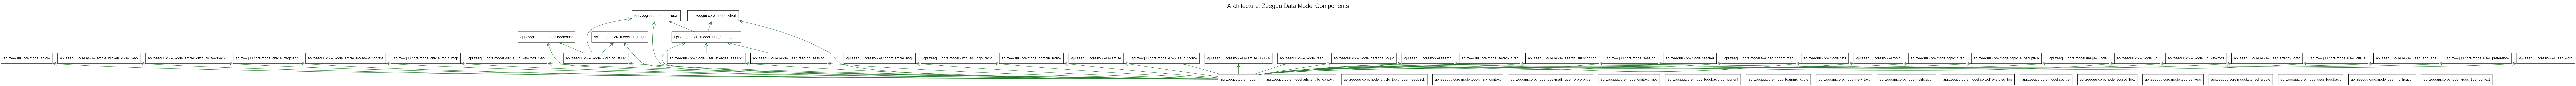

'c:\\Programming\\Architecture\\ArchitecturalRecovery\\output\\pyreverse\\custom\\zeeguu_model_view_custom.png'

In [5]:
import sys
import subprocess
from IPython.display import Image, display

# Use BASE_DIR as the project root
project_root = BASE_DIR
print("Project root:", project_root)

# Define the API repository root; note that API_DIR was defined earlier
api_repo_root = API_DIR
print("API Repository root:", api_repo_root)

# Ensure the API repository is in sys.path
if api_repo_root not in sys.path:
    sys.path.insert(0, api_repo_root)

# Use the global output directory
output_dir = PYREVERSE_OUTPUT_DIR
print("Output directory:", output_dir)

# Prepare the environment: add API repository root to PYTHONPATH
env = os.environ.copy()
env["PYTHONPATH"] = api_repo_root + os.pathsep + env.get("PYTHONPATH", "")

def customize_dot_file(input_dot, output_dot, title, node_color="#ADD8E6", edge_color="#4682B4"):
    """Customize a DOT file to improve visualization."""
    if not os.path.exists(input_dot):
        print(f"Input DOT file {input_dot} not found")
        return None
    
    with open(input_dot, 'r') as f:
        dot_content = f.read()

    import re
    digraph_pattern = r'(digraph\s+[^{]+\{)'
    styling = (
        f"\n  label=\"Architecture: {title}\";\n"
        "  fontname=\"Arial\";\n"
        "  fontsize=20;\n"
        "  labelloc=\"t\";\n"
        "  bgcolor=\"white\";\n"
        f"  node [shape=box, style=filled, fillcolor=\"{node_color}\", fontname=\"Arial\", fontsize=12];\n"
        f"  edge [color=\"{edge_color}\", penwidth=1.0, fontname=\"Arial\", fontsize=10];\n"
    )
    modified_content = re.sub(digraph_pattern, r'\1' + styling, dot_content)

    with open(output_dot, 'w') as f:
        f.write(modified_content)

    output_png = output_dot.replace('.dot', '.png')
    subprocess.check_call(["dot", "-Tpng", output_dot, "-o", output_png])
    return output_png

def create_module_view(module_name, output_name, title, ignore_patterns="test,__pycache__"):
    """Create a module viewpoint for a specific part of the system."""
    print(f"Creating module view for: {module_name}")
    
    custom_dir = os.path.join(output_dir, 'custom')
    os.makedirs(custom_dir, exist_ok=True)
    
    dot_file = os.path.join(custom_dir, f"packages_{output_name}.dot")
    
    cmd = [
        "pyreverse", module_name, "-o", "dot", "-p", output_name, "-d", custom_dir,
        "--ignore=" + ignore_patterns,
        "--module-names=y",
        "--only-classname"
    ]
    
    print("Running command:", " ".join(cmd))
    subprocess.check_call(cmd, cwd=api_repo_root, env=env)
    
    output_custom_dot = os.path.join(custom_dir, f"{output_name}_custom.dot")
    output_png = customize_dot_file(dot_file, output_custom_dot, title, node_color="#E8F5E9", edge_color="#2E7D32")
    
    if output_png and os.path.exists(output_png):
        print(f"\n{title} Viewpoint:")
        display(Image(filename=output_png))
        return output_png
    else:
        print("Failed to generate module view")
        return None

# Create module views for core API functionality and API models
create_module_view("zeeguu.core", "zeeguu_core_view", "Zeeguu Core Components")
create_module_view("zeeguu.core.model", "zeeguu_model_view", "Zeeguu Data Model Components")


## 9. Creating Customized Architecture Views

Below are helper functions that create specialized module views and a layered architecture view, as well as a metrics-enriched view using analysis from the DOT files.

Project root: c:\Programming\Architecture\ArchitecturalRecovery
API Repository root: c:\Programming\Architecture\ArchitecturalRecovery\Data\api
Output directory: c:\Programming\Architecture\ArchitecturalRecovery\output\pyreverse

Zeeguu System Architecture Layered Architecture View:


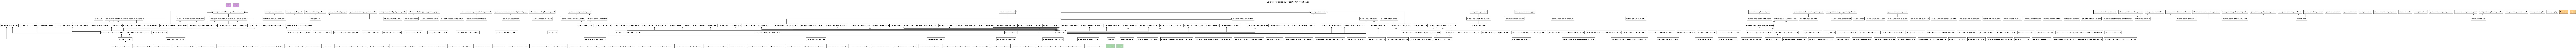

'c:\\Programming\\Architecture\\ArchitecturalRecovery\\output\\pyreverse\\zeeguu_architecture_layered.png'

In [6]:
import subprocess
from IPython.display import Image, display

# Use BASE_DIR as the project root and API_DIR as API repository root
project_root = BASE_DIR
api_repo_root = API_DIR
print("Project root:", project_root)
print("API Repository root:", api_repo_root)

# Ensure the API repository is in sys.path
if api_repo_root not in sys.path:
    sys.path.insert(0, api_repo_root)

# Use the global output directory
output_dir = PYREVERSE_OUTPUT_DIR
print("Output directory:", output_dir)

# Prepare the environment
env = os.environ.copy()
env["PYTHONPATH"] = api_repo_root + os.pathsep + env.get("PYTHONPATH", "")

def customize_dot_file(input_dot, output_dot, title, node_color="#ADD8E6", edge_color="#4682B4"):
    """Customize a DOT file to improve visualization."""
    if not os.path.exists(input_dot):
        print(f"Input DOT file {input_dot} not found")
        return None

    with open(input_dot, 'r') as f:
        dot_content = f.read()

    import re
    digraph_pattern = r'(digraph\s+[^{]+\{)'
    styling = (
        f"\n  label=\"Architecture: {title}\";\n"
        "  fontname=\"Arial\";\n"
        "  fontsize=20;\n"
        "  labelloc=\"t\";\n"
        "  bgcolor=\"white\";\n"
        f"  node [shape=box, style=filled, fillcolor=\"{node_color}\", fontname=\"Arial\", fontsize=12];\n"
        f"  edge [color=\"{edge_color}\", penwidth=1.0, fontname=\"Arial\", fontsize=10];\n"
    )
    modified_content = re.sub(digraph_pattern, r'\1' + styling, dot_content)

    with open(output_dot, 'w') as f:
        f.write(modified_content)

    output_png = output_dot.replace('.dot', '.png')
    subprocess.check_call(["dot", "-Tpng", output_dot, "-o", output_png])
    return output_png

def create_layered_view(dot_file_path, output_name, title):
    """Create a layered architecture view from a DOT file."""
    if not os.path.exists(dot_file_path):
        print(f"Input DOT file {dot_file_path} not found")
        return None

    with open(dot_file_path, 'r') as f:
        dot_content = f.read()

    output_dot = os.path.join(os.path.dirname(dot_file_path), f"{output_name}_layered.dot")

    layers = """
    // Layered architecture ranks
    { rank=same; api_modules; controllers; }
    { rank=same; core_modules; services; }
    { rank=sink; models; database; }
    
    // Layer labels
    subgraph cluster_application { label="Application Layer"; style=filled; color="#E8F5E9"; api_modules; controllers; }
    subgraph cluster_domain { label="Domain Layer"; style=filled; color="#FFF3E0"; core_modules; services; }
    subgraph cluster_data { label="Data Layer"; style=filled; color="#F3E5F5"; models; database; }
    """

    dummy_nodes = """
    // Dummy nodes for layer visualization
    api_modules [label="API Endpoints", style=filled, fillcolor="#A5D6A7"];
    controllers [label="Controllers", style=filled, fillcolor="#A5D6A7"];
    core_modules [label="Core Modules", style=filled, fillcolor="#FFCC80"];
    services [label="Services", style=filled, fillcolor="#FFCC80"];
    models [label="Models", style=filled, fillcolor="#CE93D8"];
    database [label="Database", style=filled, fillcolor="#CE93D8"];
    """

    closing_brace_pos = dot_content.rfind('}')
    if closing_brace_pos == -1:
        print("Invalid DOT file format")
        return None

    modified_content = dot_content[:closing_brace_pos] + dummy_nodes + layers + dot_content[closing_brace_pos:]

    import re
    digraph_pattern = r'(digraph\s+[^{]+\{)'
    styling = (
        f"\n  label=\"Layered Architecture: {title}\";\n"
        "  fontname=\"Arial\";\n"
        "  fontsize=20;\n"
        "  labelloc=\"t\";\n"
        "  rankdir=TB;\n"
        "  compound=true;\n"
        "  splines=ortho;\n"
        "  node [shape=box, style=filled, fontname=\"Arial\", fontsize=12];\n"
        "  edge [penwidth=1.0, fontname=\"Arial\", fontsize=10];\n"
    )
    modified_content = re.sub(digraph_pattern, r'\1' + styling, modified_content)

    with open(output_dot, 'w') as f:
        f.write(modified_content)

    output_png = output_dot.replace('.dot', '.png')
    subprocess.check_call(["dot", "-Tpng", output_dot, "-o", output_png])

    if os.path.exists(output_png):
        print(f"\n{title} Layered Architecture View:")
        display(Image(filename=output_png))
        return output_png
    else:
        print("Failed to generate layered view")
        return None

# Generate the DOT file for the entire API backend (for layered view)
dot_api = os.path.join(output_dir, 'packages_zeeguu_api_dot.dot')
if not os.path.exists(dot_api):
    cmd = [
        "pyreverse", "zeeguu", "-o", "dot", "-p", "zeeguu_api_dot", "-d", output_dir
    ]
    print("Running command:", " ".join(cmd))
    subprocess.check_call(cmd, cwd=api_repo_root, env=env)

# Create the layered architecture view using the generated DOT file
create_layered_view(dot_api, "zeeguu_architecture", "Zeeguu System Architecture")


## 10. Adding Metrics Information to the Views

Finally, we can analyze the dependency graph from a DOT file using NetworkX and pydot to compute metrics (like node count, edge count, and density) and incorporate them into the diagram.


Zeeguu API Architecture Metrics-Enriched View:


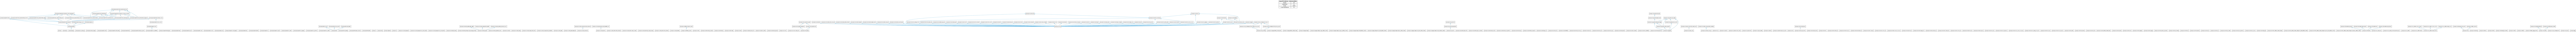

'c:\\Programming\\Architecture\\ArchitecturalRecovery\\output\\pyreverse\\zeeguu_api_metrics_metrics.png'

In [7]:
import glob
import pydot
import networkx as nx
from IPython.display import Image, display

def analyze_dependencies(dot_file):
    """Analyze module dependencies from a DOT file"""
    if not os.path.exists(dot_file):
        print(f"DOT file {dot_file} not found")
        return {}
    try:
        graphs = pydot.graph_from_dot_file(dot_file)
        if not graphs:
            print("No graph found in DOT file")
            return {}
        graph = graphs[0]
        nx_graph = nx.DiGraph()
        for node in graph.get_nodes():
            name = node.get_name().strip('"')
            nx_graph.add_node(name)
        for edge in graph.get_edges():
            source = edge.get_source().strip('"')
            dest = edge.get_destination().strip('"')
            nx_graph.add_edge(source, dest)
        metrics = {
            'node_count': nx_graph.number_of_nodes(),
            'edge_count': nx_graph.number_of_edges(),
            'density': nx.density(nx_graph),
            'in_degree': dict(nx_graph.in_degree()),
            'out_degree': dict(nx_graph.out_degree()),
            'has_cycles': len(list(nx.simple_cycles(nx_graph))) > 0
        }
        return metrics
    except Exception as e:
        print(f"Error analyzing dependencies: {e}")
        return {}

def create_metrics_enriched_view(dot_file, output_name, title):
    """Create an architectural view enriched with metrics"""
    metrics = analyze_dependencies(dot_file)
    if not metrics:
        print("Failed to analyze metrics")
        return None
    with open(dot_file, 'r') as f:
        dot_content = f.read()
        
    metrics_label = (
        "  label=<<TABLE BORDER=\"0\" CELLBORDER=\"1\" CELLSPACING=\"0\" CELLPADDING=\"4\">\n" +
        f"    <TR><TD COLSPAN=\"2\"><B>{title} - Architectural Metrics</B></TD></TR>\n" +
        f"    <TR><TD>Modules</TD><TD>{metrics['node_count']}</TD></TR>\n" +
        f"    <TR><TD>Dependencies</TD><TD>{metrics['edge_count']}</TD></TR>\n" +
        f"    <TR><TD>Density</TD><TD>{metrics['density']:.4f}</TD></TR>\n" +
        f"    <TR><TD>Circular Dependencies</TD><TD>{'Yes' if metrics['has_cycles'] else 'No'}</TD></TR>\n" +
        "  </TABLE>>;\n  labelloc=\"t\";\n"
    )
    
    import re
    modified_content = re.sub(r'(digraph\s+[^{]+\{)', 
                              lambda m: m.group(1) +
                              "\n  fontname=\"Arial\";\n"
                              "  node [shape=box, style=filled, fillcolor=\"#E1F5FE\", fontname=\"Arial\", fontsize=10];\n"
                              "  edge [color=\"#0288D1\", penwidth=1.0, fontname=\"Arial\", fontsize=8];\n"
                              + metrics_label,
                              dot_content)
    
    output_dot = os.path.join(os.path.dirname(dot_file), f"{output_name}_metrics.dot")
    with open(output_dot, 'w') as f:
        f.write(modified_content)
    
    output_png = output_dot.replace('.dot', '.png')
    result = subprocess.run(["dot", "-Tpng", output_dot, "-o", output_png],
                            capture_output=True, text=True)
    if result.returncode != 0:
        print("Dot command failed with error:")
        print(result.stderr)
        return None
    
    if os.path.exists(output_png):
        print(f"\n{title} Metrics-Enriched View:")
        display(Image(filename=output_png))
        return output_png
    else:
        print("Failed to generate metrics-enriched view")
        return None

# Use the DOT file generated earlier for the API
dot_api = os.path.join(PYREVERSE_OUTPUT_DIR, 'packages_zeeguu_api_dot.dot')
if not os.path.exists(dot_api):
    subprocess.check_call([
        "pyreverse", "zeeguu", "-o", "dot", "-p", "zeeguu_api_dot", "-d", PYREVERSE_OUTPUT_DIR
    ], cwd=API_DIR, env=env)

create_metrics_enriched_view(dot_api, "zeeguu_api_metrics", "Zeeguu API Architecture")
